# Fast Feature Extraction

## Without Data Augmentation

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.python.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from time import time
import os
import wandb
from wandb.keras import WandbCallback
import numpy as np

Using TensorFlow backend.


### Logging code

In [2]:
#TENSORBOARD_LOGS_DIR = f"dandc-{int(time())}"
#tensorboard = TensorBoard(log_dir=f"logs/{TENSORBOARD_LOGS_DIR}", write_images=True, histogram_freq=1, write_grads=True)
# run = wandb.init()
# config = run.config

### Network Configuration

In [3]:
config = {
    'img_width': 150,
    'img_height': 150,
    'first_layer_conv_width': 3,
    'first_layer_conv_height': 3,
    'dense_layer_size': 256,
    'epochs': 100,    
    'optimizer': "adam",
    'hidden_nodes': 100,
    'batch_size': 20
}

### Images Dataset

In [11]:
base_dir = 'E:\kaggle\dogs-and-cats\sm_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


### Transfer Convolutional Base

In [12]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Data Generation

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = train_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=config['batch_size'],
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * config['batch_size'] : (i + 1) * config['batch_size']] = features_batch
        labels[i * config['batch_size'] : (i + 1) * config['batch_size']] = labels_batch
        i += 1
        if i * config['batch_size'] >= sample_count:
            break
    return features, labels 

In [19]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [23]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [24]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


In [25]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Create Model

In [26]:
model = Sequential()
model.add(Dense(config['dense_layer_size'], activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


### Training

In [30]:
history = model.fit(train_features, train_labels, epochs=config['epochs'], batch_size=config['batch_size'], 
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 918us/step - loss: 0.5404 - acc: 0.7935 - val_loss: 0.2834 - val_acc: 0.8680
Epoch 2/100
2000/2000 [==============================] - 1s 470us/step - loss: 0.2293 - acc: 0.9015 - val_loss: 0.2745 - val_acc: 0.8830
Epoch 3/100
2000/2000 [==============================] - 1s 491us/step - loss: 0.1819 - acc: 0.9280 - val_loss: 0.3195 - val_acc: 0.8520
Epoch 4/100
2000/2000 [==============================] - 1s 483us/step - loss: 0.1788 - acc: 0.9275 - val_loss: 0.2893 - val_acc: 0.8630
Epoch 5/100
2000/2000 [==============================] - 1s 507us/step - loss: 0.1293 - acc: 0.9475 - val_loss: 0.2870 - val_acc: 0.8860
Epoch 6/100
2000/2000 [==============================] - 1s 477us/step - loss: 0.1169 - acc: 0.9485 - val_loss: 0.2803 - val_acc: 0.8900
Epoch 7/100
2000/2000 [==============================] - 1s 482us/step - loss: 0.0782 - acc: 0.9675 - val_loss: 0.3487 - val_acc: 

### Save model

In [31]:
model.save('candd03.h5')

### Loss & Accuracy

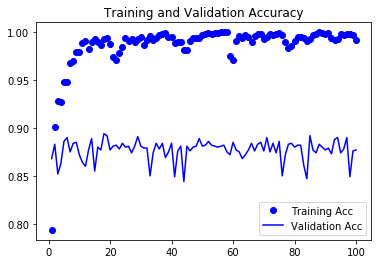

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### Training and Validation loss

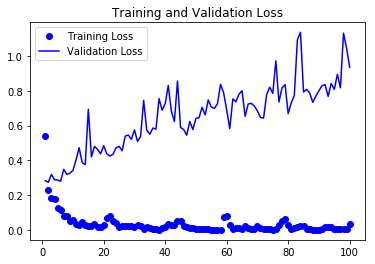

In [33]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()